## Assignment: Image recognition
- Alumno 1: Yeray Martínez Martínez
- Alumno 2: Juan Esteban Rincón Marín
- Alumno 3: Kevin Oscar Arce Vera

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

Lista de tareas para la entrega del 12 de octubre:

- [ ] EDA de los datos de rigor (desbalanceo, tipos, forma, normalizacion, etc, etc, etc)
- [ ] Data Augmentation para mejores datos y así a futuro está hecho
- [ ] La red Feedforward
- [ ] Análisis del entrenamiento y validación
- [ ] Mejoras(Ya lo vamos viendo)

# Ideas despues del seminario

1. Usar SGDR porque converge más rápido, y aquí se cobra por tiempo, no sé vosotros.
2. Lo de SB y LB está interesante, el pasar de batches pequeños a grandes ya sea con warm starting o dinamyc sampling
3. Pensar a ver si hacemos al revés el batch, el ruido al principio parece que ayuda, ya sea ocn el lr o el Batch size.
4. Aplicar SAM? ya pa tocar los huevos.
5. no sé, que alguien haga un dibujito o algo pa poner en la portada del report 

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-10-08 17:33:23.613481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
XVIEW_RECOGNITION_PATH = './data/xview_recognition/'
XVIEW_RECOGNITION_AUG_PATH = './data/xview_recognition_aug/'

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [6]:
import json

# Load database
json_file = f'{XVIEW_RECOGNITION_PATH}/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


Tomando como punto de partida este código que tan amablemente nuestro profesor nos ha dejado vemos a simple vista que el número de imágenes por clase no es del todo equitativa. Para medir el desbalanceo de las imágenes primero haremos uso de una métrica.

### Entropía de Clases
Esta es una métrica que nos permite medir cuan desbalanceado está todo el dataset y nos permitirá comparar el estado actual con el estado del dataset después de rebalancear las clases.

Este rango toma valores en el intervalo [0, log(k)] siendo k el número de clases, en este caso 13.
Cuanto mas bajo mas balanceado está el dataset, cuanto más cerca de log(13) más desbalanceado.
En caso de normalizar el valor el intervalo pasa a [0,1].

In [8]:
import math

total = sum(counts.values())  
entropy = -sum((i/total) * math.log(i/total) for i in counts.values())

print("Entropia de clases: ", entropy)
print("Valor normalizado: ", entropy/math.log(len(counts.keys())))

Entropia de clases:  2.3142789779240545
Valor normalizado:  0.9022708269821108


#### Observaciones

Observamos que si bien es verdad que el dataset no tiene las clases perfectamente balanceadas, nos da un valor de 0.90227, lo que nos indica que no hay una clase que domine por encima de las demás.

In [9]:
json_data["images"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'width': 224,
 'height': 224}

## Imágenes
Son archivos tiff que corresponden a una categoría de las 13.
Los labels estan en onehot.
La forma es de [224, 224, 3], lo que indica 3 canales de color e imágenes de 224x224.

Para el modelo se usan lo que se conoce como "generadores" que permiten cargar las imágenes en memoria en cada batch en lugar de tenerlo en un dataset ocupando memoria a lo tonto. Esto desgraciadamente choca con el data augmentation, pero yo dejo lo de normalizacion y ya me contais que os parece si lo dejamos así o probamos a hacerlo con data augmentation.

In [10]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [11]:
def generator_images(objs, batch_size, folder, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                image = load_geoimage(folder+filename).astype(np.float32)
                image = image/255 # minmax
                images.append(image)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [12]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, folder=XVIEW_RECOGNITION_PATH, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, folder=XVIEW_RECOGNITION_PATH, do_shuffle=False)

In [15]:
#esta mierda es pa sacar el maximo de los valores, se puede borrar en realidad
import numpy as np

def global_minmax(objs):
    gmin, gmax = float("inf"), float("-inf")
    for (filename, obj) in objs:
        img = load_geoimage(filename)   # (H, W, C)
        local_min = np.min(img)
        local_max = np.max(img)
        if local_min < gmin:
            gmin = local_min
        if local_max > gmax:
            gmax = local_max
    return gmin, gmax

# Uso
mn, mx = global_minmax(objs_train)
print("Mínimo global:", mn)
print("Máximo global:", mx)


RasterioIOError: ./data/xview_recognitionxview_train/Bus/12394de1-1476-4bb3-a236-77be6593fb40.tif: No such file or directory

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras import layers

class UniformNoise(layers.Layer):
    """
    Añade ruido uniforme ∈ [-width, +width] a las imágenes,
    garantizando salida en el rango [0, 1].
    """
    def __init__(self, width=0.02, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.width = width  # amplitud máxima del ruido
        self.seed = seed

    def call(self, x, training=None):
        if not training:
            return x
        # Genera ruido uniforme acotado
        noise = tf.random.uniform(tf.shape(x), -self.width, self.width, seed=self.seed, dtype=x.dtype)
        y = x + noise
        # Reencierra valores al rango [0,1]
        y = tf.clip_by_value(y, 0.0, 1.0)
        return tf.cast(y, tf.float32)

    def get_config(self):
        config = super().get_config()
        config.update({"width": self.width})
        return config


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Parámetros (ajusta a tu gusto)
IMG = 224
P_FLIP = 0.5
ROT = 0.1                # ~±10 (fracción de vuelta; 0.1≈±36º). Para ±20º usa ~0.055.
ZOOM = (-0.2, 0.0)       # zoom in hasta 20% (no zoom out). Para in/out: (-0.2, 0.2).
BRIGHT = 0.2
CONTR = 0.2
GAUSS_STD = 2/255.

data_augmentation = keras.Sequential(
    [
        layers.Resizing(IMG, IMG),
        layers.RandomFlip(mode="horizontal", seed=SEED),
        layers.RandomRotation(ROT, fill_mode="reflect", interpolation="bilinear", seed=SEED+1),
        layers.RandomZoom(height_factor=ZOOM, width_factor=ZOOM, fill_mode="reflect", seed=SEED+2),
        layers.RandomBrightness(factor=BRIGHT, value_range=[0,1], seed=SEED+3),
        layers.RandomContrast(factor=CONTR, value_range=[0,1], seed=SEED+4),
        UniformNoise(width=0.07, seed=SEED+5)
    ],
    name="aug",
)

I0000 00:00:1759937636.460749   30809 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
import random
from tensorflow import keras



SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Parámetros (ajusta a tu gusto)
IMG = 224
P_FLIP = 0.5
ROT = 0.1                # ~±10 (fracción de vuelta; 0.1≈±36º). Para ±20º usa ~0.055.
ZOOM = (-0.2, 0.0)       # zoom in hasta 20% (no zoom out). Para in/out: (-0.2, 0.2).

debalancing_aug = keras.Sequential(
    [
        layers.Resizing(IMG, IMG),
        layers.RandomFlip(mode="horizontal", seed=SEED),
        layers.RandomRotation(ROT, fill_mode="reflect", interpolation="bilinear", seed=SEED+1),
        layers.RandomZoom(height_factor=ZOOM, width_factor=ZOOM, fill_mode="reflect", seed=SEED+2),
    ],
    name="debalancing_aug",
)

Text(0.5, 1.0, 'Distribución de las Clases')

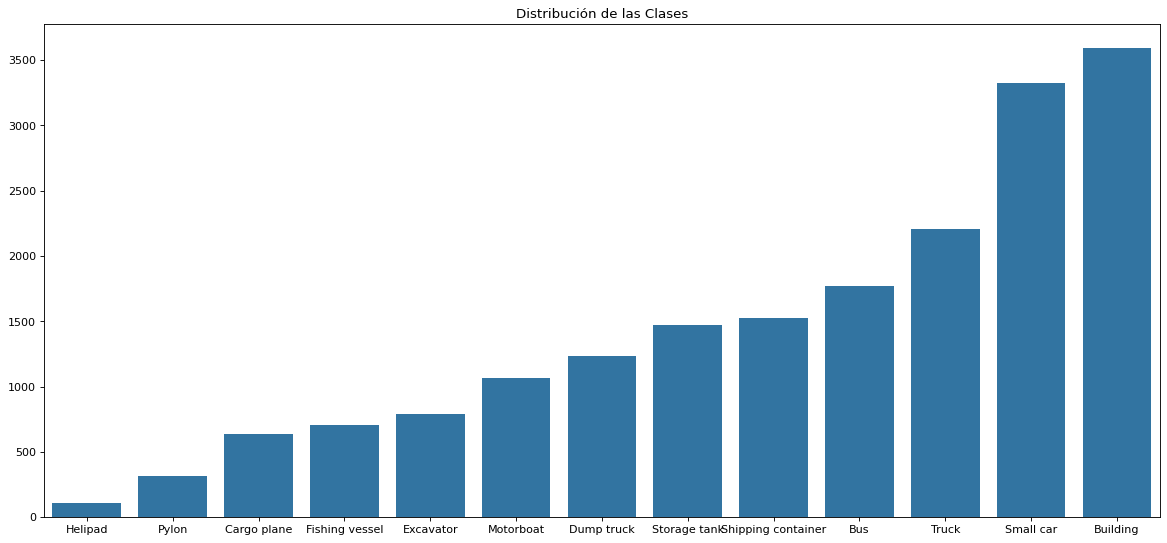

In [15]:
from matplotlib.pyplot import figure
import seaborn as sns

ordered_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}

figure(figsize=(18, 8), dpi=80)

sns.barplot(x=list(ordered_counts.keys()), y=list(ordered_counts.values()))
plt.title("Distribución de las Clases")


In [ ]:
def update_json(image_json, image_annotation, position, data, sufix=None):
    new_image = image_json.copy()
    new_image["image_id"] = new_image["image_id"].replace(".", f"{sufix}.", 1)
    new_image["filename"] = new_image["filename"].replace(".", f"{sufix}.", 1)
    new_annotation = image_annotation.copy()
    new_annotation["image_id"] = new_image["image_id"].replace(".", f"{sufix}.", 1)

    data["images"][str(position)] = new_image
    data["annotations"][str(position)] = new_annotation
    
    return data

: 

In [17]:
import json
import os

def save_json(json_data, folder, filename):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, filename)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)

In [18]:
import os
import warnings
import numpy as np
import rasterio
from rasterio.transform import from_origin

def save_tiff_rasterio(filename, img, folder):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    path = os.path.join(folder, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)

    arr = np.asarray(img)
    if arr.ndim == 2:
        arr = arr[:, :, np.newaxis]
    H, W, C = arr.shape

    # Asegura dtype compatible
    if arr.dtype == np.float64:
        arr = arr.astype(np.float32)

    profile = {
        "driver": "GTiff",
        "height": H,
        "width": W,
        "count": C,
        "dtype": str(arr.dtype),
        "crs": None,                          # sin georreferencia
        "transform": from_origin(0, 0, 1, 1), # pixel size 1, origen (0,0)
        "compress": "lzw",                    # opcional
        # "interleave": "pixel",              # opcional
    }

    with rasterio.open(path, "w", **profile) as dst:
        # escribir por banda con memoria contigua
        for b in range(C):
            dst.write(np.ascontiguousarray(arr[:, :, b]), b + 1)

        # ColorInterp: más compatible que 'photometric'
        try:
            from rasterio.enums import ColorInterp
            if C == 3:
                dst.colorinterp = (ColorInterp.red, ColorInterp.green, ColorInterp.blue)
            elif C == 4:
                dst.colorinterp = (ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.alpha)
            elif C == 1:
                dst.colorinterp = (ColorInterp.gray,)
        except Exception:
            pass

    return path

In [19]:
def delete_and_shift(d, key_to_remove):
    key_to_remove = str(key_to_remove)
    # 1. Elimina la clave
    d.pop(key_to_remove, None)
    # 2. Crea una lista ordenada de claves
    keys = sorted(d.keys(), key=lambda k: int(k))
    # 3. Reconstruye con nuevas claves
    new_d = {}
    for i, k in enumerate(keys):
        new_d[str(i)] = d[k]
    return new_d

In [ ]:
us_categories = ["Helipad", "Pylon", "Cargo plane", "Fishing vessel", "Excavator"]
os_categories = ["Small car", "Building"]

p_us = 0.5

p_os = 0.3

image_counter = len(json_data["images"])
json_output = json_data.copy()

fuck = []

for i in range(len(json_data["images"])):
    image_json = json_data["images"][str(i)].copy()
    image_annotation = json_data["annotations"][str(i)].copy()
    if image_annotation["category_id"] in us_categories:
        if tf.random.uniform(shape=[]) <= p_us:
            img_in = load_geoimage(XVIEW_RECOGNITION_PATH + image_json["filename"])/255
            img_out = tf.cast(debalancing_aug(img_in, training=True)*255, dtype=tf.uint8)
            
            update_json(image_json, image_annotation, image_counter, json_output)
            image_counter += 1
            
            save_tiff_rasterio(image_json["filename"], img_out, folder=XVIEW_RECOGNITION_AUG_PATH)
    if image_annotation["category_id"] in os_categories:
        if tf.random.uniform(shape=[]) <= p_os:
            fuck.append(i)


for i in fuck:
    delete_and_shift(json_output["images"], i)
    delete_and_shift(json_output["annotations"], i)
    

save_json(json_output, XVIEW_RECOGNITION_AUG_PATH, "xview_ann_train.json")


In [ ]:
from typing import List

def process_data(src_path, dest_path=None, *,
                 augmentation_prob=0.0,
                 augmentation_fn=None,
                 undersampling_prob=0.0,
                 oversampling_prob=0.0,
                 undersampling_classes: List[str]=None,
                 oversampling_classes: List[str]=None,
                 debalancing_fn=None):
    '''
    Processes the dataset.

    Parameters
    ----------
    src_path : str
        The source path containing the original dataset.
    dest_path : str
        The destination path where the augmented dataset will be saved. If None, the original dataset will be overwritten.
    augmentation_prob : float
        The augmentation probability to apply to all classes. Uses a uniform random distribution.
    augmentation_fn : callable
        The function to use for data augmentation.
    undersampling_prob : float
        The probability by which to undersample the specified classes. Uses a uniform random distribution.
    oversampling_prob : float
        The probability by which to oversample the specified classes. Uses a uniform random distribution.
    undersampling_classes : List[str]
        The list of classes to undersample.
    oversampling_classes : List[str]
        The list of classes to oversample.
    debalancing_fn : callable
        The function to use for debalancing augmentation.
    '''

    # Validate parameters
    if undersampling_prob > 0 and undersampling_classes is None:
        raise ValueError("Undersampling classes must be specified when undersampling probability is greater than 0.")

    if oversampling_prob > 0 and oversampling_classes is None:
        raise ValueError("Oversampling classes must be specified when oversampling probability is greater than 0.")
    
    if augmentation_prob > 0 and augmentation_fn is None:
        raise ValueError("Augmentation function must be specified when augmentation probability is greater than 0.")

    if oversampling_prob > 0 and debalancing_fn is None:
        raise ValueError("Debalancing augmentation function must be specified when oversampling probability is greater than 0.")
    
    if dest_path is None:
        dest_path = src_path

    # Load the original JSON data
    data = json.load(open(os.path.join(src_path, 'xview_ann_train.json')))

    image_counter = len(data["images"])
    json_output = data.copy()
    delete_images = []

    for i in range(len(data["images"])):
        image_json = data["images"][str(i)].copy()
        image_annotation = data["annotations"][str(i)].copy()

        # Apply undersampling
        if undersampling_classes and image_annotation["category_id"] in undersampling_classes:
            if tf.random.uniform(shape=[]) <= undersampling_prob:
                delete_images.append(i)
                continue
        
        # Apply oversampling
        if oversampling_classes and image_annotation["category_id"] in oversampling_classes:
            if tf.random.uniform(shape=[]) <= oversampling_prob:
                img_in = load_geoimage(os.path.join(src_path, image_json["filename"]))/255
                img_out = tf.cast(debalancing_fn(img_in, training=True)*255, dtype=tf.uint8)
                
                update_json(image_json, image_annotation, image_counter, json_output, sufix='_oversampled')
                image_counter += 1
                
                save_tiff_rasterio(image_json["filename"], img_out, folder=dest_path)

        # Apply augmentation
        if tf.random.uniform(shape=[]) <= augmentation_prob:
            img = load_geoimage(os.path.join(src_path, image_json["filename"]))/255
            img = tf.cast(augmentation_fn(img, training=True)*255, dtype=tf.uint8)

            update_json(image_json, image_annotation, i, json_output, sufix='_augmented')

            save_tiff_rasterio(image_json["filename"], img, folder=dest_path)
    
    # Fix JSON by removing deleted images and shifting keys
    for i in delete_images:
        delete_and_shift(json_output["images"], i)
        delete_and_shift(json_output["annotations"], i)
    
    # Save the new JSON data
    save_json(json_output, dest_path, 'xview_ann_train.json')

In [21]:
os_classes = ["Helipad", "Pylon", "Cargo plane", "Fishing vessel", "Excavator"]
us_classes = ["Small car", "Building"]

process_data(
    src_path=XVIEW_RECOGNITION_PATH,
    dest_path=XVIEW_RECOGNITION_AUG_PATH,
    augmentation_prob=0.0,
    augmentation_fn=None,
    undersampling_prob=0.3,
    oversampling_prob=0.5,
    undersampling_classes=us_classes,
    oversampling_classes=os_classes,
    debalancing_fn=debalancing_aug
)

In [50]:
json_data["images"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'width': 224,
 'height': 224}

In [51]:
json_data["annotations"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'category_id': 'Building',
 'bbox': [0, 0, 224, 224]}

In [22]:
import json

# Load database
json_file_aug = f'{XVIEW_RECOGNITION_AUG_PATH}/xview_ann_train.json'
with open(json_file_aug) as ifs:
    json_data_aug = json.load(ifs)
ifs.close()

In [35]:
import numpy as np

counts_aug = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data_aug['images'].values(), json_data_aug['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts_aug[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
counts_aug

{'Cargo plane': 956,
 'Small car': 2337,
 'Bus': 1768,
 'Truck': 2210,
 'Motorboat': 1069,
 'Fishing vessel': 1051,
 'Dump truck': 1236,
 'Excavator': 1183,
 'Building': 2533,
 'Helipad': 175,
 'Storage tank': 1469,
 'Shipping container': 1523,
 'Pylon': 480}

Text(0.5, 1.0, 'Distribución de las Clases Aumentadas')

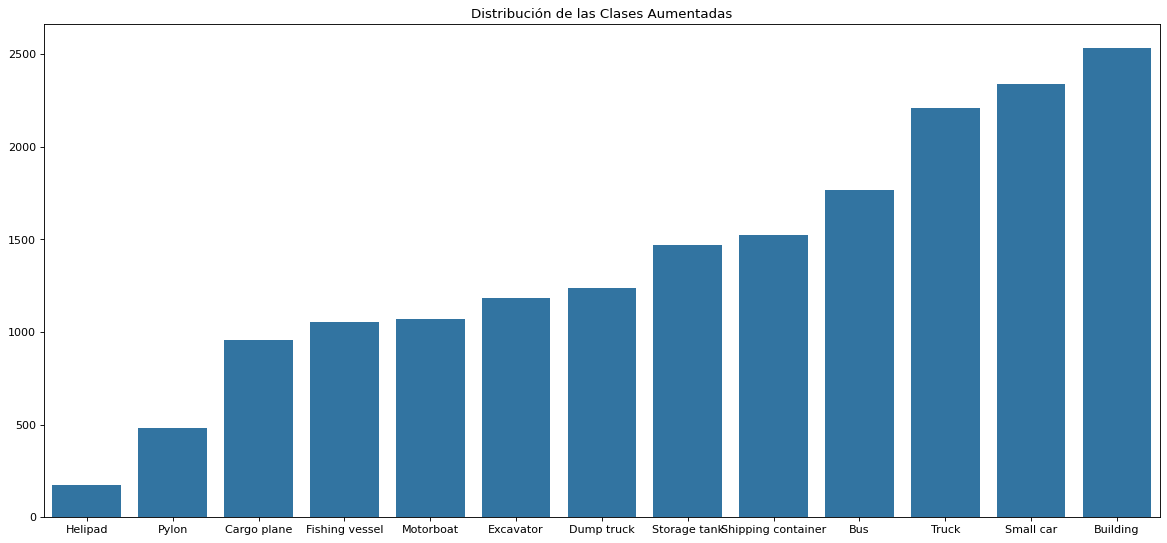

In [24]:
from matplotlib.pyplot import figure
import seaborn as sns

ordered_counts_aug = {k: v for k, v in sorted(counts_aug.items(), key=lambda item: item[1])}

figure(figsize=(18, 8), dpi=80)

sns.barplot(x=list(ordered_counts_aug.keys()), y=list(ordered_counts_aug.values()))
plt.title("Distribución de las Clases Aumentadas")

In [25]:
print("Diferencia inicial: ", max(counts.values()) - min(counts.values()))

Diferencia inicial:  3483


In [29]:
print("Diferencia aumentados: ", max(counts_aug.values()) - min(counts_aug.values()))

Diferencia aumentados:  2422


In [27]:
counts

{'Cargo plane': 635,
 'Small car': 3324,
 'Bus': 1768,
 'Truck': 2210,
 'Motorboat': 1069,
 'Fishing vessel': 706,
 'Dump truck': 1236,
 'Excavator': 789,
 'Building': 3594,
 'Helipad': 111,
 'Storage tank': 1469,
 'Shipping container': 1523,
 'Pylon': 312}

In [35]:
us_classes

['Small car', 'Building']

In [38]:
os_classes

['Helipad', 'Pylon', 'Cargo plane', 'Fishing vessel', 'Excavator']

In [34]:
## Check augmented images distribution in actual folders

counts_aug_folder = dict.fromkeys(categories.values(), 0)

import os

# Iterate through all images via folder
for folder in os.listdir(XVIEW_RECOGNITION_AUG_PATH+"/xview_train/"):
    for file in os.listdir(os.path.join(XVIEW_RECOGNITION_AUG_PATH+"/xview_train/", folder)):
        if file.endswith('.tif'):
            category_name = folder
            if category_name in counts_aug_folder:
                counts_aug_folder[category_name] += 1

counts_aug_folder

{'Cargo plane': 635,
 'Small car': 2337,
 'Bus': 1768,
 'Truck': 2210,
 'Motorboat': 1069,
 'Fishing vessel': 706,
 'Dump truck': 1236,
 'Excavator': 789,
 'Building': 2533,
 'Helipad': 111,
 'Storage tank': 1469,
 'Shipping container': 1523,
 'Pylon': 312}

# PRUEBAS

In [166]:
np.min(load_geoimage(filename=json_data["images"]["34"]["filename"]))

np.uint8(0)

In [167]:
load_geoimage(filename=json_data["images"]["34"]["filename"])

array([[[20, 29, 12],
        [20, 29, 12],
        [20, 29, 12],
        ...,
        [ 4, 10,  3],
        [ 3,  7,  2],
        [ 1,  3,  1]],

       [[20, 29, 12],
        [20, 29, 12],
        [20, 29, 12],
        ...,
        [ 3,  8,  3],
        [ 2,  6,  2],
        [ 1,  3,  1]],

       [[21, 30, 13],
        [21, 30, 12],
        [21, 30, 12],
        ...,
        [ 2,  7,  2],
        [ 2,  5,  1],
        [ 1,  2,  1]],

       ...,

       [[18, 27,  9],
        [18, 27,  9],
        [18, 27,  9],
        ...,
        [11, 22,  7],
        [ 7, 15,  5],
        [ 4,  7,  2]],

       [[12, 18,  6],
        [12, 18,  6],
        [12, 18,  6],
        ...,
        [ 7, 14,  4],
        [ 5, 10,  3],
        [ 2,  5,  1]],

       [[ 6,  9,  3],
        [ 6,  9,  3],
        [ 6,  9,  3],
        ...,
        [ 4,  8,  2],
        [ 3,  5,  2],
        [ 1,  3,  1]]], shape=(224, 224, 3), dtype=uint8)

In [168]:
load_geoimage(filename=json_data["images"]["34"]["filename"])

array([[[20, 29, 12],
        [20, 29, 12],
        [20, 29, 12],
        ...,
        [ 4, 10,  3],
        [ 3,  7,  2],
        [ 1,  3,  1]],

       [[20, 29, 12],
        [20, 29, 12],
        [20, 29, 12],
        ...,
        [ 3,  8,  3],
        [ 2,  6,  2],
        [ 1,  3,  1]],

       [[21, 30, 13],
        [21, 30, 12],
        [21, 30, 12],
        ...,
        [ 2,  7,  2],
        [ 2,  5,  1],
        [ 1,  2,  1]],

       ...,

       [[18, 27,  9],
        [18, 27,  9],
        [18, 27,  9],
        ...,
        [11, 22,  7],
        [ 7, 15,  5],
        [ 4,  7,  2]],

       [[12, 18,  6],
        [12, 18,  6],
        [12, 18,  6],
        ...,
        [ 7, 14,  4],
        [ 5, 10,  3],
        [ 2,  5,  1]],

       [[ 6,  9,  3],
        [ 6,  9,  3],
        [ 6,  9,  3],
        ...,
        [ 4,  8,  2],
        [ 3,  5,  2],
        [ 1,  3,  1]]], shape=(224, 224, 3), dtype=uint8)

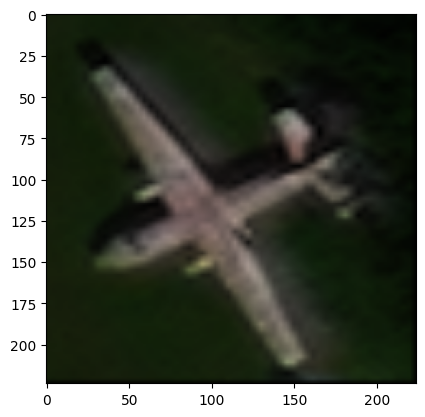

In [195]:
from matplotlib.pyplot import imshow

imshow(load_geoimage(filename=json_data["images"]["34"]["filename"]))

In [253]:
import rasterio
from rasterio.transform import from_origin
import numpy as np
import warnings
import os

def save_geoimage(filename, img, folder="./data/"):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    os.makedirs(folder, exist_ok=True)
    output_path = os.path.join(folder, filename)
    img = np.asarray(img)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
    height, width, bands = img.shape
    profile = {
        "driver": "GTiff",
        "dtype": str(img.dtype),
        "count": bands,
        "height": height,
        "width": width,
        "crs": None,
        "transform": from_origin(0, 0, 1, 1)
    }
    with rasterio.open(output_path, "w", **profile) as dst:
        for b in range(bands):
            dst.write(img[:, :, b], b + 1)


In [254]:
def update_json(image_json, image_annotation, position, data):
    image_json["image_id"] = image_json["image_id"].replace(".", "_augmented.", 1)
    image_json["filename"] = image_json["filename"].replace(".", "_augmented.", 1)
    image_annotation["image_id"] = image_json["image_id"].replace(".", "_augmented.", 1)
    
    data["images"][str(position)] = image_json
    data["annotations"][str(position)] = image_annotation
    
    return data

In [255]:
import json
import os

def save_json(json_data, folder, filename):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, filename)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)

In [257]:
import os
import warnings
import numpy as np
import rasterio
from rasterio.transform import from_origin

def save_tiff_rasterio(filename, img, folder="./data/"):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, filename)

    arr = np.asarray(img)
    if arr.ndim == 2:
        arr = arr[:, :, np.newaxis]
    H, W, C = arr.shape

    # Asegura dtype compatible
    if arr.dtype == np.float64:
        arr = arr.astype(np.float32)

    profile = {
        "driver": "GTiff",
        "height": H,
        "width": W,
        "count": C,
        "dtype": str(arr.dtype),
        "crs": None,                          # sin georreferencia
        "transform": from_origin(0, 0, 1, 1), # pixel size 1, origen (0,0)
        "compress": "lzw",                    # opcional
        # "interleave": "pixel",              # opcional
    }

    with rasterio.open(path, "w", **profile) as dst:
        # escribir por banda con memoria contigua
        for b in range(C):
            dst.write(np.ascontiguousarray(arr[:, :, b]), b + 1)

        # ColorInterp: más compatible que 'photometric'
        try:
            from rasterio.enums import ColorInterp
            if C == 3:
                dst.colorinterp = (ColorInterp.red, ColorInterp.green, ColorInterp.blue)
            elif C == 4:
                dst.colorinterp = (ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.alpha)
            elif C == 1:
                dst.colorinterp = (ColorInterp.gray,)
        except Exception:
            pass

    return path


In [258]:

us_categories = ["Helipad", "Pylon", "Cargo plane", "Fishing vessel", "Excavator"]
os_categories = ["Small car", "Building"]

p_us = 0.5

image_counter = len(json_data["images"])
json_output = json_data.copy()

fuck = []

for i in range(len(json_data["images"])):
    image_json = json_data["images"][str(i)].copy()
    image_annotation = json_data["annotations"][str(i)].copy()
    if image_annotation["category_id"] in us_categories:
        if tf.random.uniform(shape=[]) <= p_us:
            img_in = load_geoimage(image_json["filename"])/255
            img_out = tf.cast(debalancing_aug(img_in, training=True)*255, dtype=tf.uint8)
            
            update_json(image_json, image_annotation, image_counter, json_output)
            image_counter += 1
            
            save_tiff_rasterio(image_json["filename"], img_out, folder="./pilotes/data/")

save_json(json_output, "./pilotes/data/", "xview_ann_train.json")
            
        
        
    

In [203]:
json_parcial = {"info":"", "categories": json_data["categories"], "images": {}, "annotations": {}}

for i in range(5):
    json_parcial["images"][str(i)] = json_data["images"][str(i)].copy()
    json_parcial["annotations"][str(i)] = json_data["annotations"][str(i)].copy()

In [208]:
len(json_data["images"])

18746

In [207]:
display(json_data["images"].keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [205]:
from matplotlib.pyplot import imshow


image_json = json_data["images"]["34"].copy()
image_annotation = json_data["annotations"]["34"].copy()

json_parcial = update_json(image_json, image_annotation, 32, json_parcial)


display(json_parcial["images"])

display(json_parcial["annotations"])

{'0': {'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
  'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
  'width': 224,
  'height': 224},
 '1': {'image_id': 'f2543073-9933-44c4-98e0-15eee2dffe2a.tif',
  'filename': 'xview_train/Building/f2543073-9933-44c4-98e0-15eee2dffe2a.tif',
  'width': 224,
  'height': 224},
 '2': {'image_id': '6df5b6a5-82b0-4abb-8deb-7d7154c977bc.tif',
  'filename': 'xview_train/Building/6df5b6a5-82b0-4abb-8deb-7d7154c977bc.tif',
  'width': 224,
  'height': 224},
 '3': {'image_id': 'ddbd2636-ce3c-4406-a5cf-92fa557dbd3c.tif',
  'filename': 'xview_train/Building/ddbd2636-ce3c-4406-a5cf-92fa557dbd3c.tif',
  'width': 224,
  'height': 224},
 '4': {'image_id': '609064d1-3719-4163-ad36-577dab9805f0.tif',
  'filename': 'xview_train/Building/609064d1-3719-4163-ad36-577dab9805f0.tif',
  'width': 224,
  'height': 224},
 '32': {'image_id': '3fb20871-2516-4cf3-8cdc-078c5f059919_augmented.tif',
  'filename': 'xview_train/Cargo plane/3fb2087

{'0': {'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
  'category_id': 'Building',
  'bbox': [0, 0, 224, 224]},
 '1': {'image_id': 'f2543073-9933-44c4-98e0-15eee2dffe2a.tif',
  'category_id': 'Building',
  'bbox': [0, 0, 224, 224]},
 '2': {'image_id': '6df5b6a5-82b0-4abb-8deb-7d7154c977bc.tif',
  'category_id': 'Building',
  'bbox': [0, 0, 224, 224]},
 '3': {'image_id': 'ddbd2636-ce3c-4406-a5cf-92fa557dbd3c.tif',
  'category_id': 'Building',
  'bbox': [0, 0, 224, 224]},
 '4': {'image_id': '609064d1-3719-4163-ad36-577dab9805f0.tif',
  'category_id': 'Building',
  'bbox': [0, 0, 224, 224]},
 '32': {'image_id': '3fb20871-2516-4cf3-8cdc-078c5f059919_augmented_augmented.tif',
  'category_id': 'Cargo plane',
  'bbox': [0, 0, 224, 224]}}

In [176]:
json_parcial["annotations"].keys()

dict_keys(['0', '1', '2', '3', '4', '32'])

In [177]:
display(json_data["images"]["0"].keys())

dict_keys(['image_id', 'filename', 'width', 'height'])

In [178]:
display(json_data["images"]["0"])
display(json_data["annotations"]["0"])

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'width': 224,
 'height': 224}

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'category_id': 'Building',
 'bbox': [0, 0, 224, 224]}

In [179]:

display(json_data["annotations"]["0"]["image_id"].replace(".", "_augmented.", 1))

'0234476c-a017-4c9b-bd2f-872193076cca_augmented.tif'

In [180]:
image = load_geoimage(filename=json_data["images"]["34"]["filename"])
image

RasterioIOError: ./data/xview_train/Cargo plane/3fb20871-2516-4cf3-8cdc-078c5f059919_augmneted.tif: No such file or directory

In [ ]:
save_geoimage("avion_pichau.tiff", image, folder="./pilotes/")

In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./data/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [ ]:
len(fuck[0])

2

In [ ]:
fuck[0][1]

<tf.Tensor: shape=(224, 224, 3), dtype=int32, numpy=
array([[[35, 37, 27],
        [35, 36, 26],
        [34, 36, 26],
        ...,
        [44, 41, 25],
        [44, 41, 25],
        [44, 40, 25]],

       [[35, 37, 27],
        [35, 36, 26],
        [34, 36, 26],
        ...,
        [44, 41, 25],
        [44, 41, 25],
        [44, 40, 25]],

       [[35, 37, 26],
        [35, 36, 26],
        [34, 36, 25],
        ...,
        [43, 41, 25],
        [44, 41, 25],
        [43, 40, 25]],

       ...,

       [[16, 21, 16],
        [16, 21, 16],
        [15, 20, 15],
        ...,
        [23, 22, 15],
        [31, 30, 20],
        [36, 34, 23]],

       [[16, 21, 16],
        [16, 20, 16],
        [15, 19, 15],
        ...,
        [24, 23, 15],
        [31, 30, 20],
        [36, 35, 23]],

       [[16, 21, 16],
        [16, 20, 16],
        [15, 20, 15],
        ...,
        [24, 24, 15],
        [31, 31, 19],
        [36, 35, 23]]], shape=(224, 224, 3), dtype=int32)>

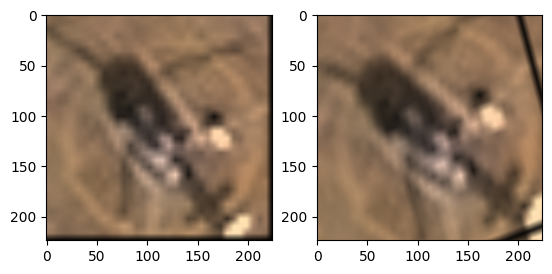

In [ ]:

index = 5

plt.subplot(1, 2, 1)
imshow(fuck[index][0])

plt.subplot(1, 2, 2)
imshow(fuck[index][1])
plt.show()

In [ ]:
json_data.keys()

dict_keys(['info', 'images', 'annotations', 'categories'])

In [ ]:
json_data["annotations"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'category_id': 'Building',
 'bbox': [0, 0, 224, 224]}

In [ ]:
json_data["images"]["0"]

{'image_id': '0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'filename': 'xview_train/Building/0234476c-a017-4c9b-bd2f-872193076cca.tif',
 'width': 224,
 'height': 224}

In [ ]:
len(json_data["annotations"])

18746

In [ ]:
len(json_data["images"])

18746

In [ ]:
json_data["categories"]

{'0': {'id': 13,
  'name': 'Cargo plane',
  'supercategory': 'Fixed wing aircraft'},
 '1': {'id': 18, 'name': 'Small car', 'supercategory': 'Passenger vehicle'},
 '2': {'id': 19, 'name': 'Bus', 'supercategory': 'Passenger vehicle'},
 '3': {'id': 23, 'name': 'Truck', 'supercategory': 'Truck'},
 '4': {'id': 41, 'name': 'Motorboat', 'supercategory': 'Maritime vessel'},
 '5': {'id': 47, 'name': 'Fishing vessel', 'supercategory': 'Maritime vessel'},
 '6': {'id': 60, 'name': 'Dump truck', 'supercategory': 'Engineering vehicle'},
 '7': {'id': 64, 'name': 'Excavator', 'supercategory': 'Engineering vehicle'},
 '8': {'id': 73, 'name': 'Building', 'supercategory': 'Building'},
 '9': {'id': 84, 'name': 'Helipad', 'supercategory': 'Helipad'},
 '10': {'id': 86, 'name': 'Storage tank', 'supercategory': 'Storage tank'},
 '11': {'id': 91,
  'name': 'Shipping container',
  'supercategory': 'Shipping container'},
 '12': {'id': 93, 'name': 'Pylon', 'supercategory': 'Pylon'}}

[IN]  dtype: float32 min: 0.0 max: 1.0
[OUT] dtype: <dtype: 'float32'> min: 1.4901161193847656e-08 max: 0.9999995827674866


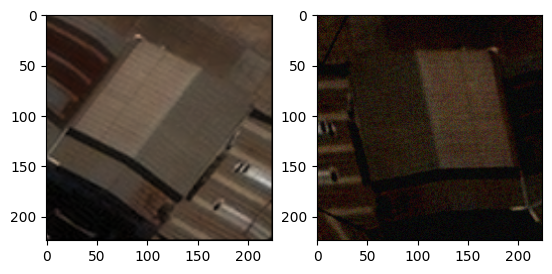

In [ ]:
from matplotlib.pyplot import imshow

imgs_in, _ = next(train_generator)

print(
    "[IN]  dtype:", imgs_in.dtype,
    "min:", float(np.min(imgs_in)),
    "max:", float(np.max(imgs_in))
)

qwerty = data_augmentation(imgs_in, training=True)

print(
    "[OUT] dtype:", qwerty.dtype,
    "min:", float(tf.reduce_min(qwerty)),
    "max:", float(tf.reduce_max(qwerty))
)


plt.subplot(1, 2, 1)
imshow(imgs_in[0])

plt.subplot(1, 2, 2)
imshow(qwerty[0])
plt.show()


In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [ ]:

# === DATASETS POR CLASE (balanceo al vuelo) ===
def make_ds(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    def _map(path, y):
        img = read_image(path)                 # 0..1, (H,W,C)
        if training:
            img = augment(img)                 # augment solo en train
        else:
            img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(y, tf.int32)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    return ds